Issues with concentrations. Acetone

In [1]:
from os.path import dirname, join, pardir
from cobra.io import read_sbml_model
from dfba import DfbaModel, ExchangeFlux, KineticVariable
from dfba.plot.matplotlib import *
import numpy as np
import math

from IPython.display import Image
from IPython.core.display import HTML

# Define Process Parameters

In [2]:
data_dir = "/Users/phivri/Documents/GitHubCleanup/MoGeoCoCult"

Schematic of the envisioned bubbel column setup, as assessed by Redl et al.


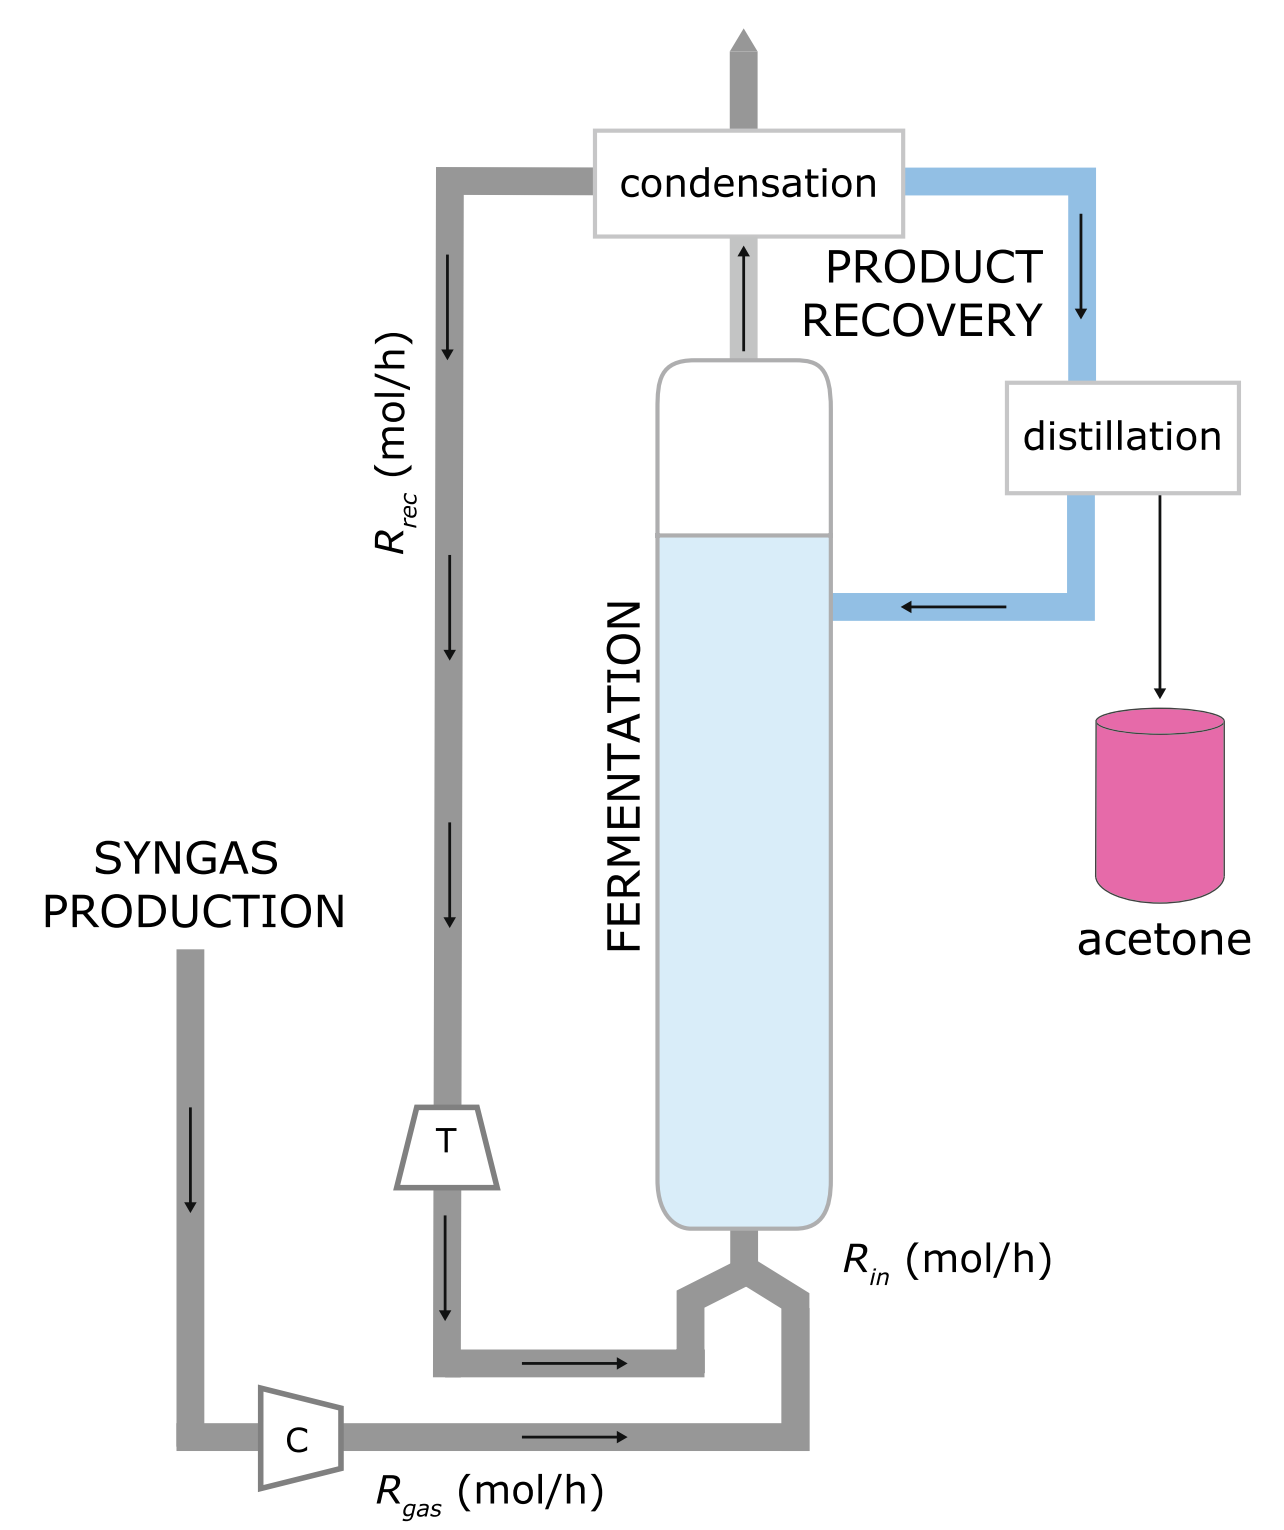

In [3]:
T = 332.15#-35 #Temperature in Kelvin
R = 8.314 # [m^3*Pa/K/mol]
t_rn = 200.0 # Run time [h]

#Reactor
F_L = 0.01 #Fluid inflow rate with C-source supplement [m^3]
F_G = 1*10**4 #gas inflow rate (from Steph: (8*10**5 * 8.314 * T)/p_m) [m^3/h]
r = 3 # radius of the reactor [m]
h = 30 # height of the reactor [m]

#mol fraction of incoming gas
y_co = 0.4 #[mol/mol]
y_co2 = 0.2 #[mol/mol]
y_h2 = 0.3 #[mol/mol]
y_o2 = 0.0 #[mol/mol]
y_n2 = 0.0 #[mol/mol]

#Concentration of substrates in inflow:
C_Sucr_in = 0.8*1.4/0.342 * 10**3# concentration of glucose in syrup (0.8 g/g glucose, 1.4 kg/l density, 0,182 kg/mol molar weight)

print("Schematic of the envisioned bubbel column setup, as assessed by Redl et al.")
Image(filename= join(data_dir, "Figures", "BubbleColumnSchematic.jpg"), width=400, height=400)

In [4]:
#deduceable parameters
A = math.pi * r**2 #reactor cross-sectional area [m^2]
V_L = A * h * 2/3 #reactor volume, assuming it is 2/3 filled [m^3]
v_gas = F_G/A/3600 #average gas velocity [m/s]
Gas_holdup = 0.6*(v_gas)**0.7 #from Stephanie's paper
V_G = V_L*Gas_holdup

p_t = 101325 # pressure at the top of the reactor [Pa]
p_b = p_t + h * 1000 * 9.81 # pressure at the bottom of the reactor [Pa]
p_m = (p_b-p_t)/math.log(p_b/p_t) # logarithmic mean pressure [Pa]

# Biological Parameters Acetogen

### Energy Requirements for Growth and Overall Stoichiometry
\[REF] Heijnen J.J. (2010) Impact of Thermodynamic Principles in Systems Biology. In: Wittmann C., Krull R. (eds) Biosystems Engineering II. Advances in Biochemical Engineering / Biotechnology, vol 121. Springer, Berlin, Heidelberg. https://doi.org/10.1007/10_2009_63

In [5]:
a_G = 1000 #kJ/CmolX
print("a_G =", a_G, "[kJ/CmolX]")

a_G = 1000 [kJ/CmolX]


### Energy Requirements for Maintenance

\[REF]: L. Tijhuis, M.C. M. van Loosdrecht, and J. J. Heijnen, A Thermodynamically Based Correlation for Maintenance Gibbs Energy Requirements in Aerobic and Anaerobic Chemotrophic Growth 

In [6]:
m_G = 3.3**(69000/R*(1/298-1/T)) #[kJ/h/CmolX]
print("m_G =", round(m_G,2), "[kJ/h/CmolX]")

m_G = 30.53 [kJ/h/CmolX]


# Calculate Gibbs Free Energy and Enthalpy

<p>Given the reaction stoichiometries:</p>
<p>$ -2 CO_2 - 4 H_2 + CH_3COOH + 2 H_2O $</p>
<p>$ -4 CO - 2 H_2O + CH_3COOH + 2 CO_2 $</p>

In [7]:
#Gibbs energy of Formation at 298.15
DfG0_actn = -159.7 #[kJ/mol]
DfG0_actt = -389.9 #[kJ/mol]
DfG0_co2 = -394.4 #[kJ/mol]
DfG0_co = -137.2 #[kJ/mol]
DfG0_h2o = -237.1 #[kJ/mol]
DfG0_h2 = 0 #[kJ/mol]
DfG0_ch4 = -50.53 #[kJ/mol]

#standard molar enthalpy
DfH0_actn = -249.4 #[KJ/mol]
DfH0_actt = -483.5 #[KJ/mol]
DfH0_co2 = -394.4 #[KJ/mol]
DfH0_co = -110.5 #[KJ/mol]
DfH0_h2o = -285.8 #[KJ/mol]
DfH0_h2 = 0 #[KJ/mol]
DfH0_ch4 = -74.8 #[KJ/mol]

#Hess's law:
DrG0_carb = -4*DfG0_co - 2*DfG0_h2o + DfG0_actt + 2*DfG0_co2
DrG0_hom = -4*DfG0_h2 - 2*DfG0_co2 + DfG0_actt + 2*DfG0_h2o 

print("Gibbs energy:\n",
      " DrG0_carb =",round(DrG0_carb,1),"[kJ/mol]\n",
      " DrG0_hom =",round(DrG0_hom,1),"[kJ/mol]\n")

DrH0_carb = -4*DfH0_co - 2*DfH0_h2o + DfH0_actt + 2*DfH0_co2
DrH0_hom = -4*DfH0_h2 - 2*DfH0_co2 + DfH0_actt + 2*DfH0_h2o

print("Enthalpy:\n",
      " DrH0_carb =", round(DrH0_carb,1),"[kJ/mol]\n",
      " DrH0_hom =", round(DrH0_hom,1),"[kJ/mol]\n")

#Gibbs–Helmholtz equation for temperature correction
DrGT_carb = DrG0_carb * (T/298.15) + DrH0_carb * (1-T/298.15)
DrGT_hom = DrG0_hom * (T/298.15) + DrH0_hom * (1-T/298.15)

print("Temperature corrected Gibbs energy:\n",
      " DrGT_carb =",round(DrGT_carb,1),"[kJ/mol]\n",
      " DrGT_hom =",round(DrGT_hom,1),"[kJ/mol]")

#dropped concentration correction, in accordance with book

Gibbs energy:
  DrG0_carb = -155.7 [kJ/mol]
  DrG0_hom = -75.3 [kJ/mol]

Enthalpy:
  DrH0_carb = -258.7 [kJ/mol]
  DrH0_hom = -266.3 [kJ/mol]

Temperature corrected Gibbs energy:
  DrGT_carb = -144.0 [kJ/mol]
  DrGT_hom = -53.5 [kJ/mol]


Reaction-specific substrate requirement for growth:

In [8]:
a_CO = a_G/(DrGT_carb/4) #based on stoichiometry of electron donor
a_H2 = a_G/(DrGT_hom/4) #based on stoichiometry of electron donor

print("Substrate required for growth:\n",
      "a_CO = ",round(a_CO,1), "[molCO/CmolX]\n",
      "a_H2 = ",round(a_H2,1), "[molH2/CmolX]")

Substrate required for growth:
 a_CO =  -27.8 [molCO/CmolX]
 a_H2 =  -74.7 [molH2/CmolX]


## Determine anabolic reaction, biomass formation stoichiometry

<p>With an apporximated biomass composition of $ CH_{1.8}O_{0.5}N_{0.2} $ and ammonia, $ NH_3 $ as carbon source, a prediction of the stoichiometry for the biomass formation reaction can be made by balancing out all elements in each of the reactions:</p>

<p>$ -r_{CO2} CO_2 - r_{H} H_2 - r_{Am} NH_3 + CH_{1.8}O_{0.5}N_{0.2} + r_{W} H_2O = 0$ </p>
<p>$ -r_{CO} CO - r_{W} H_2O - r_{Am} NH_3 + CH_{1.8}O_{0.5}N_{0.2} + r_{CO2} CO_2 = 0$</p>

Which results in:

<p>$ -CO_2 - 2.1 H_2 - 0.2 NH_3 + CH_{1.8}O_{0.5}N_{0.2} + 1.5 H_2O = 0$ </p>
<p>$ -2.1 CO - 0.6 H_2O - 0.2 NH_3 + CH_{1.8}O_{0.5}N_{0.2} + 1.1 CO_2 = 0$</p>

### Combine catabolic and anabolic reactions

#### Carboxydotrophic

In [9]:
r_carb_CO = -2.1+4*a_CO/4
r_carb_W = -0.6+2*a_CO/4
r_carb_Am = -0.2
r_carb_X = 1
r_carb_actt = -a_CO/4
r_carb_CO2 = 1.1-2*a_CO/4

print(f"Overall Carboxydotrophic stoichiometry at {T}K: \n {round(r_carb_CO,2)} CO {round(r_carb_W,2)} H20 {round(r_carb_Am,2)} NH3 + {round(r_carb_X,2)} biomass + {round(r_carb_actt,2)} CH3COOH + {round(r_carb_CO2,2)} CO2 = 0 \n")

print("Yields on substrate:","\n",
      "r_carb_CO =", round(r_carb_CO,2), "\n",
      "r_carb_W =", round(r_carb_W,2), "\n",
      "r_carb_Am =", round(r_carb_Am,2), "\n",
      "r_carb_X =", round(r_carb_X,2), "\n",
      "r_carb_actt =", round(r_carb_actt,2), "\n",
      "r_carb_CO2 =", round(r_carb_CO2,2), "\n",
      "Y_carb_XS =", round(r_carb_X/r_carb_CO,3), "\n",
      "Y_carb_PS =", round(r_carb_actt/r_carb_CO,3), "\n",
      "Y_carb_PX =", round(r_carb_actt/r_carb_X,3))

Overall Carboxydotrophic stoichiometry at 332.15K: 
 -29.89 CO -14.49 H20 -0.2 NH3 + 1 biomass + 6.95 CH3COOH + 14.99 CO2 = 0 

Yields on substrate: 
 r_carb_CO = -29.89 
 r_carb_W = -14.49 
 r_carb_Am = -0.2 
 r_carb_X = 1 
 r_carb_actt = 6.95 
 r_carb_CO2 = 14.99 
 Y_carb_XS = -0.033 
 Y_carb_PS = -0.232 
 Y_carb_PX = 6.947


#### Homoacetogenic

In [10]:
r_hom_CO2 = -1 + 2*a_H2/4
r_hom_H2 = -2.1 + 4*a_H2/4
r_hom_Am = -0.2
r_hom_X = 1
r_hom_actt = -a_H2/4
r_hom_W = 1.5 - 2*a_H2/4

print(f"Overall Homoacetogenic stoichiometry at {T}K: \n {round(r_hom_CO2,2)} CO2 {round(r_hom_H2,2)} H2 {round(r_hom_Am,2)} NH3 + {round(r_hom_X,2)} biomass + {round(r_hom_actt,2)} CH3COOH + {round(r_hom_W,2)} H2O = 0 \n")


print("Yields on substrate:","\n",
      "r_hom_CO2 =", round(r_hom_CO2,2), "\n",
      "r_hom_H2 =", round(r_hom_H2,2), "\n",
      "r_hom_Am =", round(r_hom_Am,2), "\n",
      "r_hom_X =", round(r_hom_X,2), "\n",
      "r_hom_actt =", round(r_hom_actt,2), "\n",
      "r_hom_W =", round(r_hom_W,2), "\n",
      "Y_homo_XS =", round(r_hom_X/r_hom_H2,3), "\n",
      "Y_homo_PS =", round(r_hom_actt/r_hom_H2,3), "\n",
      "Y_homo_PX =", round(r_hom_actt/r_hom_X,3))

Overall Homoacetogenic stoichiometry at 332.15K: 
 -38.37 CO2 -76.84 H2 -0.2 NH3 + 1 biomass + 18.68 CH3COOH + 38.87 H2O = 0 

Yields on substrate: 
 r_hom_CO2 = -38.37 
 r_hom_H2 = -76.84 
 r_hom_Am = -0.2 
 r_hom_X = 1 
 r_hom_actt = 18.68 
 r_hom_W = 38.87 
 Y_homo_XS = -0.013 
 Y_homo_PS = -0.243 
 Y_homo_PX = 18.685


#### Reaction-specific substrate requirement for maintenance:

In [11]:
m_carb = m_G/(DrGT_carb/4) #[molCO/h/CmolX] based on stoichiometry of electron donor
m_hom = m_G/(DrGT_hom/4) #[molCO/h/CmolX] based on stoichiometry of electron donor

print("Substrate required for maintenance:\n",
      "m_carb = ",round(m_carb,1), "[molCO/h/CmolX]\n",
      "m_hom = ",round(m_hom,1), "[molH2/h/CmolX]")

Substrate required for maintenance:
 m_carb =  -0.8 [molCO/h/CmolX]
 m_hom =  -2.3 [molH2/h/CmolX]


### Michaelis-Menten Parameters

In [12]:
Ks_h2_ace =  0.000033 # from BRENDA, Clostridium acetobutylicum [mM]
Ks_co2_ace =  1 # from BRENDA, middle of a wide range: 0.0157 - 50 [mM]
Ks_co_ace = 0.01 # from BRENDA, Moorella thermoacetica [mM]

Ki_actt_ace = 813.6 #mM Inhibition constant for acetate, from Moorella

µ_max_hom = 8.140/24 #[/h]
µ_max_carb = 3.910/24 #[/h] 

- CODH for CO: https://www.brenda-enzymes.org/enzyme.php?ecno=1.2.7.4 
- formate dehydrogenase for CO2: https://www.brenda-enzymes.org/enzyme.php?ecno=1.17.1.9
- ferredoxin hydrogenase for H2: https://www.brenda-enzymes.org/enzyme.php?ecno=1.12.7.2

In [13]:
Ks_gluc_het = 0.00165 # From Daniel, Source?
Ks_actt_het = 1.97 # From Daniel, Source? Maybe this transporter, no data: https://www.uniprot.org/uniprot/A0A1B7KU88

#Ki_actt_het = 20 #Experimentally seen to be 40 times lower than Moorella's

# Define Transfer Rates as Functions

## Gas transfer rates

<p>For gasses that are poorly soluble in aqueous solutions, such as all the gases in the feed stream of this simulation, the mass transfer accros the phase boundary is dominated by the gas-phase film resistance. At the liquid side of the boundary, the gas concentration $C_{AGi}$ is at saturation $C_{AL}^*$. Temperature and partial pressure will determine the saturation concentration, and thus the transfer rate.</p>

<p>For a gas "A", the transfer rate is following the equation:</p>
<p>$ N_A = K_La * (C_{AL}^* - C_{AL})$</p>


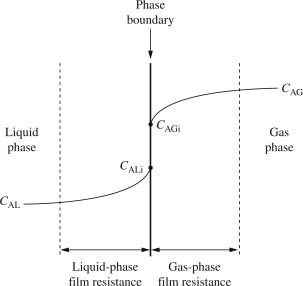

In [14]:
Image(filename= join(data_dir, "Figures", "LG_MassTransfer.jpg"))

In [15]:
# Constants:
# Diffusivity coefficient:
# E.L. Cussler, Diffusion - Mass Transfer in Fluid Systems, 2nd edition - Table 5.2-1
D0_CO = 2.03*10**(-5) #[cm2/s]
D0_CO2 = 1.92*10**(-5) #[cm2/s]
D0_H2 = 4.50*10**(-5) #[cm2/s]
D0_O2 = 2.10*10**(-5) #[cm2/s]
D0_N2 = 1.88*10**(-5) #[cm2/s]

# NIST Chemistry WebBook: https://webbook.nist.gov
theta = 1.022 # temperature correction factor
#Henry's law constant for solubility in water at 298.15 K
H0_CO = 0.00099 # mol/kg*bar]
H0_CO2 = 0.035 # [mol/kg*bar]
H0_H2 = 0.00078 # [mol/kg*bar]
H0_O2 = 0.0013 # [mol/kg*bar]
H0_N2 = 0.0006 # [mol/kg*bar]
#temepratute correction factor k 
k_CO = 1300 # [K]
k_CO2 = 2400 # [K]
k_H2 = 500 # [K]
k_O2 = 1500 # [K]
k_N2 = 1300 # [K]

#Temperature-corrected Henry’s law constant, HT:
HT_CO2 = H0_CO2 * math.e**(k_CO2*(1/T-1/298.15)) * 10**3 * 10**(-5) #[mol/m^3*Pa]
HT_CO = H0_CO * math.e**(k_CO*(1/T-1/298.15)) * 10**3 * 10**(-5) #[mol/m^3*Pa]
HT_H2 = H0_H2 * math.e**(k_H2*(1/T-1/298.15)) * 10**3 * 10**(-5) #[mol/m^3*Pa]
HT_O2 = H0_O2 * math.e**(k_O2*(1/T-1/298.15)) * 10**3 * 10**(-5) #[mol/m^3*Pa]
HT_N2 = H0_N2 * math.e**(k_N2*(1/T-1/298.15)) * 10**3 * 10**(-5) #[mol/m^3*Pa]

#Calculate kLa for each gas, all are poorly water-soluble so kLa >> kGa:
KLa_CO2 = 0.32 * (D0_CO2/D0_O2)**0.5 * v_gas**0.7 * theta**(T-293.15) * 3600 #[1/s]
KLa_CO = 0.32 * (D0_CO/D0_O2)**0.5 * v_gas**0.7 * theta**(T-293.15) * 3600 #[1/s]
KLa_H2 = 0.32 * (D0_H2/D0_O2)**0.5 * v_gas**0.7 * theta**(T-293.15) * 3600 #[1/s]
KLa_O2 = 0.32 * (1)**0.5 * v_gas**0.7 * theta**(T-293.15) * 3600 #[1/s]
KLa_N2 = 0.32 * (D0_N2/D0_O2)**0.5 * v_gas**0.7 * theta**(T-293.15) * 3600 #[1/s]

#Define functions to calculate gas mass transfer rates for each gas
def R_CO2(c_co2,cG_co2,cG_Gas):
    #cG_Gas = sum(cG_co2,args)
    return KLa_CO2*(HT_CO2 * cG_co2/(cG_Gas) * p_m * cG_Gas/CG_Gas_0 - c_co2)

def R_CO(c_co,cG_co,cG_Gas):
    #cG_Gas = sum(cG_Gas,args)
    return KLa_CO*(HT_CO * cG_co/(cG_Gas) * p_m * cG_Gas/CG_Gas_0 - c_co)

def R_H2(c_h2,cG_h2,cG_Gas):
    #cG_Gas = sum(cG_h2,args)
    return KLa_H2*(HT_H2 * cG_h2/(cG_Gas) * p_m * cG_Gas/CG_Gas_0 - c_h2)

def R_O2(c_o2,cG_o2,cG_Gas):
    #cG_Gas = sum(cG_o2,args)
    return KLa_O2*(HT_O2 * cG_o2/(cG_Gas) * p_m * cG_Gas/CG_Gas_0 - c_o2)

def R_N2(c_n2,cG_n2,cG_Gas):
    #cG_Gas = sum(cG_n2,args)
    return KLa_N2*(HT_N2 * cG_n2/(cG_Gas) * p_m * cG_Gas/CG_Gas_0 - c_n2)

## Acetone Evaporation Rate

Assuming that all evaporation happens through gas stripping, instead of boiling, the evaporation rate can be determined based on the partial pressure of the volatile compound, temperature corrected and at a given concentration.

required equations:
 - Clausius–Clapeyron Equation
 
<p>$ P_T = e^{RT/{\Delta H_{vap}}+C}$</p>

 - Raoult's law: the partial pressure of each component of an ideal mixture of liquids is equal to the vapor pressure of the pure component multiplied by its mole fraction in the mixture
 
<p>$ p_i = p_i^* * x_i$</p>

 - Ideal gas law
 
<p>$ P*V = n*R*T$</p>
 
<p>For a metabolite "A", the evaporative transfer rate is following the equation:</p>
<p>$ N_A = K_Ga * (C_{AG} - C_{AG}^*)$</p>

In [16]:
# Diffusion coefficients in air at reference temperature at 25°C, std pressure:
# R.C. Roberts Molecular Diffusion of gasses
DGR_H2O = 0.219 * 10**(-4) #[m2/s]
# G. A. Lugg, Diffusion Coefficients of Some Organic and Other Vapors in Air
DGR_Actn = 0.1049 * 10**(-4) #[m2/s]

DH_vap_Actn = 3.1 * 10**4 #J/mol https://webbook.nist.gov/cgi/cbook.cgi?ID=C67641&Mask=4#Thermo-Phase
DH_vap_H2O = 4.3 * 10**4 #J/mol no single source, range 4.6-4.0 between 0-100°C

#From: http://www.ddbst.com/en/EED/PCP/PCPindex.php
P0_Actn = 9290.0 # [Pa] at 272.95K http://www.ddbst.com/en/EED/PCP/VAP_C4.php
P0_H2O = 2400.0 # [Pa] at 293.15K http://www.ddbst.com/en/EED/PCP/VAP_C174.php

T0_Actn = 272.95 #K http://www.ddbst.com/en/EED/PCP/VAP_C4.php
T0_H2O = 293.15 #K http://www.ddbst.com/en/EED/PCP/VAP_C174.php

d_vs = 0.005 # [m] bubble diameter, mid of range for coarse bubbles
a = 3.6 * (v_gas)**0.7 / d_vs
c_H2O = 10**6/18


def R_Actn(cG, c):
    kGR = 2.78 * DGR_Actn**0.5 * v_gas**0.18
    kGTa = 1#kGR * a * theta**(T-293.15) #[1/s]
    C = math.log(P0_Actn) + DH_vap/(R*T0_Actn)
    Pt = math.e**(-DH_vap/(R*T) + C) * c/c_H2O
    cG_sat = Pt/(R*T)
    return kGTa * (cG-cG_sat)

def R_H2O(cG, c):
    kGR = 2.78 * DGR_H2O**0.5 * v_gas**0.18
    kGTa = 1#kGR * a * theta**(T-293.15) #[1/s]
    C = math.log(P0_H2O) + DH_vap/(R*T0_H2O)
    Pt = math.e**(-DH_vap/(R*T) + C) * c/c_H2O
    cG_sat = Pt/(R*T)
    return kGTa * (cG-cG_sat)

In [17]:
DH_vap_Actn = 3.1 * 10**4 #J/mol https://webbook.nist.gov/cgi/cbook.cgi?ID=C67641&Mask=4#Thermo-Phase
DH_vap_H2O = 4.3 * 10**4 #J/mol no single source, range 4.6-4.0 between 0-100°C

#From: http://www.ddbst.com/en/EED/PCP/PCPindex.php
P0_Actn = 9290.0 # [Pa] at 272.95K http://www.ddbst.com/en/EED/PCP/VAP_C4.php
P0_H2O = 2400.0 # [Pa] at 293.15K http://www.ddbst.com/en/EED/PCP/VAP_C174.php

T0_Actn = 272.95 #K http://www.ddbst.com/en/EED/PCP/VAP_C4.php
T0_H2O = 293.15 #K http://www.ddbst.com/en/EED/PCP/VAP_C174.php

#Calculate the constant C, the intersection with the y-axis
C_Actn = np.log(P0_Actn) + DH_vap_Actn/(R*T0_Actn)

print("T0 =", T0_Actn, "\nP0 =", P0_Actn, "\nC =", C_Actn)

Pt = np.exp(-DH_vap_Actn/(R*T) + C_Actn)

Kga_actn = 2.78 * DGR_H2O**0.5 * v_gas**0.18 * a * theta**(T-293.15)# Arbitrarly chosen, find better value if possible

def R_actn(cG_actn,c_actn):
    cG_sat = c_actn/(1000000/18)*Pt/(R*T)
    return Kga_actn*(cG_actn - cG_sat)

T0 = 272.95 
P0 = 9290.0 
C = 22.797256092618603


In [18]:
#DH_vap = 3.1 * 10**(4) #J/mol https://webbook.nist.gov/cgi/cbook.cgi?ID=C67641&Mask=4#Thermo-Phase
#T0, P0 = 272.95, 9290 #http://www.ddbst.com/en/EED/PCP/VAP_C4.php

#Calculate the constant C, the intersection with the y-axis
#C = np.log(P0) + DH_vap/(R*T0)

#print("T0 =", T0, "\nP0 =", P0, "\nC =", C)
#
#Pt = np.exp(-DH_vap/(R*T) + C)

#Kga_actn = 1 # Arbitrarly chosen, find better value if possible

#def R_actn(cG_actn,c_actn):
#    cG_sat = c_actn/(1000/18)*Pt/(R*T)
#    return Kga_actn*(cG_actn - cG_sat)

# Set up Black Box Model for Acetogens
## Homoacetogenic

In [19]:
def µ_hom(C_h2, C_co2, C_actt):
    return µ_max_hom * C_h2/(Ks_h2_ace+C_h2) * C_co2/(Ks_co2_ace+C_co2) * (1-C_actt/Ki_actt_ace)

def q_hom_CO2(C_h2, C_co2, C_actt):
    return µ_hom(C_h2, C_co2, C_actt)/(r_hom_X/r_hom_CO2) + (-2/-4) * m_hom

def q_hom_H2(C_h2, C_co2, C_actt):
    return µ_hom(C_h2, C_co2, C_actt)/(r_hom_X/r_hom_H2) + m_hom

def q_hom_actt(C_h2, C_co2, C_actt):
    return µ_hom(C_h2, C_co2, C_actt)/(r_hom_X/r_hom_actt) + (1/-4) * m_hom

## Carboxydotrophic

In [20]:
def µ_carb(C_co, C_actt):
    return µ_max_carb * C_co/(Ks_co_ace+C_co) * (1-C_actt/Ki_actt_ace)

def q_carb_CO(C_co, C_actt):
    return µ_carb(C_co, C_actt)/(r_carb_X/r_carb_CO) + m_carb

def q_carb_actt(C_co, C_actt):
    return µ_carb(C_co, C_actt)/(r_carb_X/r_carb_actt) + (1/-4) * m_carb

def q_carb_CO2(C_co, C_actt):
    return µ_carb(C_co, C_actt)/(r_carb_X/r_carb_CO2) + (2/-4) * m_carb

# Load Geobacillus GEM and Adapt to dFBA Package

In [21]:
model = read_sbml_model(join(data_dir,'Models/p-thermo_acetone_anaerobic.xml'))

### Force acetone production

When optimizing for biomass, acetate will not be consumed and acetone not produced anaerobically. This is contrary to laboratory observations.

There are several strategies to reflect this in the model: 
 * constrain the minimal uptake of acetate to force its consumption
 * set a complex objective funtion, optimizing for a ratio of biomass to acetone
 * set growth to e.g. 80% of maximum yield on substrate, then optimize for product formation

In [22]:
medium = model.medium
medium["EX_sucr_e"] = 5.0
medium["EX_glc__D_e"] = 0.0
model.medium = medium

solution = model.optimize()

Y_XS_max = solution.fluxes.EX_Biomass_e/solution.fluxes.EX_sucr_e

print(f"The maximum yield on sucrose is {Y_XS_max}")

ratio = 0.8

print(f"The acetone producing strain is expected to grow to a minimum of {ratio*100}% of its maximum Biomass yield on")

The maximum yield on sucrose is -0.02488393668269443
The acetone producing strain is expected to grow to a minimum of 80.0% of its maximum Biomass yield on


In [23]:
MaxGrowth = model.problem.Constraint(
    model.reactions.EX_Biomass_e.flux_expression - Y_XS_max * ratio * model.reactions.EX_sucr_e.flux_expression,
    lb=0,
    ub=1000)
model.add_cons_vars(MaxGrowth)

In [24]:
model.reactions.EX_ac_e.bounds = (-1000, 0)
model.reactions.EX_sucr_e.bounds = (0, 5)

medium = model.medium
#medium["EX_sucr_e"] = 5
#medium["EX_glc__D_e"] = 0
medium["EX_o2_e"] = 1000.0
medium["EX_ac_e"] = 1000.0
model.medium = medium

model.objective = 'EX_act_e'

In [25]:
model.solver = "glpk"
dfba_model = DfbaModel(model)

# Set up dFBA

In [26]:
#initial conditions
CG_CO2_in = y_co2 * p_m/(R*T)
CG_CO_in = y_co * p_m/(R*T)
CG_H2_in = y_h2 * p_m/(R*T)
CG_O2_in = y_o2 * p_m/(R*T)
CG_N2_in = y_n2 * p_m/(R*T)
CG_Actn_in = 0.0

C_CO2_0 = HT_CO2 * y_co2 * p_m
C_CO_0 =  HT_CO * y_co * p_m
C_H2_0 =  HT_H2 * y_h2 * p_m
C_O2_0 =  HT_O2 * y_o2 * p_m
C_N2_0 =  HT_H2 * y_n2 * p_m

C_X_car_0 = 1
C_X_hom_0 = 1
C_X_het_0 = 0.1
C_Sucr_0 = 15.0
C_Actt_0 = 10.0
C_Actn_0 = 0.0

C_Actn_acc_0 = 0.0

CG_Gas_0 = CG_CO2_in+CG_CO_in+CG_H2_in+CG_O2_in+CG_N2_in

In [27]:
# instances of ExchangeFlux
µ_het = ExchangeFlux("EX_Biomass_e")
q_het_Sucr = ExchangeFlux("EX_sucr_e")
q_het_Actt = ExchangeFlux("EX_ac_e")
q_het_Actn = ExchangeFlux("EX_act_e")
q_het_O2 = ExchangeFlux("EX_o2_e")
q_het_CO2 = ExchangeFlux("EX_co2_e")

In [28]:
# instances of KineticVariable
C_X_car = KineticVariable("Carboxydotroph")
C_X_hom = KineticVariable("Homoacetogen")
C_X_het = KineticVariable("Heterotroph")
C_Sucr = KineticVariable("Sucrose")
C_Actt = KineticVariable("Acetate")
C_Actn = KineticVariable("Acetone")
C_CO2 = KineticVariable("CO2")
C_CO = KineticVariable("CO")
C_H2 = KineticVariable("H2")
C_O2 = KineticVariable("O2")
C_N2 = KineticVariable("N2")
CG_CO2 = KineticVariable("G_CO2")
CG_CO = KineticVariable("G_CO")
CG_H2 = KineticVariable("G_H2")
CG_O2 = KineticVariable("G_O2")
CG_N2 = KineticVariable("G_N2")
CG_Actn = KineticVariable("G_Actn")
#CG_H2O = KineticVariable("G_H2O")
CG_Gas = KineticVariable("G_Gas")
C_Actn_acc = KineticVariable("Actn_acc")

# add kinetic variables to dfba_model
dfba_model.add_kinetic_variables([C_X_car,C_X_hom,C_X_het,C_Sucr,C_Actt,C_Actn,C_CO2,C_CO,C_H2,C_O2,C_N2,CG_CO2,CG_CO,CG_H2,CG_O2,CG_N2,CG_Actn,CG_Gas,C_Actn_acc])

# add exchange fluxes to dfba_model
dfba_model.add_exchange_fluxes([µ_het, q_het_Sucr, q_het_Actt, q_het_Actn, q_het_O2, q_het_CO2])

# add rhs expressions for kinetic variables in dfba_model
#Biomass balances:
dfba_model.add_rhs_expression("Carboxydotroph", µ_carb(C_CO, C_Actt) * C_X_car)
dfba_model.add_rhs_expression("Homoacetogen", µ_hom(C_H2, C_CO, C_Actt) * C_X_hom)
dfba_model.add_rhs_expression("Heterotroph", µ_het * C_X_het)
#Concentration balances of solutes in broth
dfba_model.add_rhs_expression("Sucrose", q_het_Sucr * C_X_het + F_L * C_Sucr_in)
dfba_model.add_rhs_expression("Acetate", q_het_Actt * C_X_het + q_hom_actt(C_H2, C_CO2, C_Actt) * C_X_hom + q_carb_actt(C_CO, C_Actt) * C_X_car)
dfba_model.add_rhs_expression("Acetone", q_het_Actn * C_X_het + R_actn(CG_Actn,C_Actn))
#Concentration balances of disolved gasses
dfba_model.add_rhs_expression("CO2", q_het_CO2 * C_X_het + q_hom_CO2(C_H2, C_CO2, C_Actt) * C_X_hom + q_carb_CO2(C_CO, C_Actt) * C_X_car + R_CO2(C_CO2,CG_CO2,CG_Gas))
dfba_model.add_rhs_expression("CO", q_carb_CO(C_CO, C_Actt) * C_X_car + R_CO(C_CO,CG_CO,CG_Gas))
dfba_model.add_rhs_expression("H2", q_hom_H2(C_H2, C_CO2, C_Actt) * C_X_hom + R_H2(C_H2,CG_H2,CG_Gas))
dfba_model.add_rhs_expression("O2", q_het_O2 * C_X_het+ R_O2(C_O2,CG_O2,CG_Gas))
dfba_model.add_rhs_expression("N2", R_N2(C_N2,CG_N2,CG_Gas))
#Mass balances of gasses in gas phase
dfba_model.add_rhs_expression("G_CO2", F_G/V_G * (CG_CO2_in-CG_CO2) - R_CO2(C_CO2,CG_CO2,CG_Gas) * V_L/V_G)
dfba_model.add_rhs_expression("G_CO", F_G/V_G * (CG_CO_in-CG_CO) - R_CO(C_CO,CG_CO,CG_Gas) * V_L/V_G)
dfba_model.add_rhs_expression("G_H2", F_G/V_G * (CG_H2_in-CG_H2) - R_H2(C_H2,CG_H2,CG_Gas) * V_L/V_G)
dfba_model.add_rhs_expression("G_O2", F_G/V_G * (CG_O2_in-CG_O2) - R_O2(C_O2,CG_O2,CG_Gas) * V_L/V_G)
dfba_model.add_rhs_expression("G_N2", F_G/V_G * (CG_N2_in-CG_N2) - R_N2(C_N2,CG_N2,CG_Gas) * V_L/V_G)
dfba_model.add_rhs_expression("G_Actn", F_G/V_G * (0-CG_Actn) - R_actn(CG_Actn,C_Actn) * V_L/V_G)
#dfba_model.add_rhs_expression("G_H2O", F_G/V_G * (0-CG_H2O) - R_H2O(C_N2,CG_N2,CG_Gas) * V_L/V_G)
dfba_model.add_rhs_expression("G_Gas", CG_CO2+CG_CO+CG_H2+CG_O2+CG_N2+CG_Actn)
#Concentration balance of accumulated acetone
dfba_model.add_rhs_expression("Actn_acc", F_G/V_G * (CG_Actn-0))


# add lower/upper bound expressions for exchange fluxes in dfba_model together
# with expression that must be non-negative for correct evaluation of bounds
dfba_model.add_exchange_flux_lb("EX_sucr_e", 10.5 * (C_Sucr / (0.0027 + C_Sucr)), C_Sucr)
dfba_model.add_exchange_flux_lb("EX_ac_e", 15.0 * (C_Actt / (0.024 + C_Actt)), C_Actt)
dfba_model.add_exchange_flux_lb("EX_o2_e", 15.0 * (C_O2 / (0.024 + C_O2)), C_O2) #!!change values
#dfba_model.add_exchange_flux_ub("EX_ac_e", -10, C_Actt)

# add initial conditions for kinetic variables in dfba_model biomass (gDW/L),
# metabolites (g/L)
dfba_model.add_initial_conditions(
    {
        "Carboxydotroph": C_X_car_0,
        "Homoacetogen": C_X_hom_0, 
        "Heterotroph": C_X_het_0, 
        "Sucrose": C_Sucr_0, 
        "Acetate": C_Actt_0, 
        "Acetone": C_Actn_0, 
        "CO2": C_CO2_0, 
        "CO": C_CO_0,
        "H2": C_H2_0,
        "O2": C_O2_0, 
        "N2": C_N2_0,
        "G_CO2": CG_CO2_in,
        "G_CO": CG_CO_in,
        "G_H2": CG_H2_in,
        "G_O2": CG_O2_in,
        "G_N2": CG_N2_in,
        "G_Actn": CG_Actn_in,
        "Actn_acc": C_Actn_acc_0
    }
)

# simulate model across interval t = [0.0,25.0](hours) with outputs for plotting
# every 0.1h and optional list of fluxes
#concentrations = dfba_model.simulate(0.0, 25.0, 0.1)#, ["EX_Biomass_e","EX_glc__D_e", "EX_ac_e", "EX_act_e"])
#dfba_model.solver_data.set_algorithm("direct")
#dfba_model.solver_data.set_display("none")
#dfba_model.solver_data.set_ode_method("ADAMS")

concentrations, trajectories = dfba_model.simulate(0.0, t_rn, 0.1, ["EX_Biomass_e","EX_sucr_e", "EX_ac_e", "EX_act_e", "EX_for_e","EX_etoh_e","EX_co2_e","EX_o2_e"])
#concentrations = dfba_model.simulate(0.0, 20.0, 0.1)

In [29]:
concentrations = concentrations.set_index("time")

cols = ["Carboxydotroph","Homoacetogen","Heterotroph","Sucrose","Acetate","Acetone","CO2","CO","H2","O2","N2","G_CO2","G_CO","G_H2","G_O2","G_N2","G_Actn","Actn_acc"]
concentrations = concentrations[cols]
concentrations

,Carboxydotroph,Homoacetogen,Heterotroph,Sucrose,Acetate,Acetone,CO2,CO,H2,O2,N2,G_CO2,G_CO,G_H2,G_O2,G_N2,G_Actn,Actn_acc
time,,,,,,,,,,,,,,,,,,
0.0,1.000000,1.000000,0.100000,15.000000,10.000000,0.000000,6.634604,0.547556,0.425827,0.0,0.0,15.647907,31.295815,23.471861,0.0,0.0,0.000000,0.000000
0.1,1.015944,1.012510,0.102112,18.168764,10.590253,0.355149,7.256332,0.591325,0.412022,0.0,0.0,15.419021,30.976018,22.049027,0.0,0.0,0.000032,0.000226
0.2,1.032130,1.025176,0.104269,21.335286,11.188072,0.717769,7.284013,0.591065,0.411259,0.0,0.0,15.474437,30.971170,22.031033,0.0,0.0,0.000067,0.000963
0.3,1.048561,1.037987,0.106471,24.499518,11.792064,1.088019,7.284157,0.590801,0.410529,0.0,0.0,15.474698,30.966213,22.014034,0.0,0.0,0.000102,0.002223
0.4,1.065242,1.050945,0.108720,27.661402,12.402178,1.466088,7.285651,0.590532,0.409789,0.0,0.0,15.477660,30.961188,21.996814,0.0,0.0,0.000138,0.004021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159.3,233.192758,11.044258,104.251026,0.000083,0.002046,23677.142320,17.309993,0.000034,-0.248726,0.0,0.0,35.289895,19.891977,6.657396,0.0,0.0,2.264667,27417.158455
159.4,233.205512,11.044270,104.316219,0.000083,0.002045,23688.053877,17.308539,0.000034,-0.248724,0.0,0.0,35.287021,19.891975,6.657447,0.0,0.0,2.265711,27451.037093
159.5,233.218231,11.044283,104.381412,0.000083,0.002043,23698.958465,17.307085,0.000034,-0.248721,0.0,0.0,35.284147,19.891973,6.657498,0.0,0.0,2.266754,27484.931328


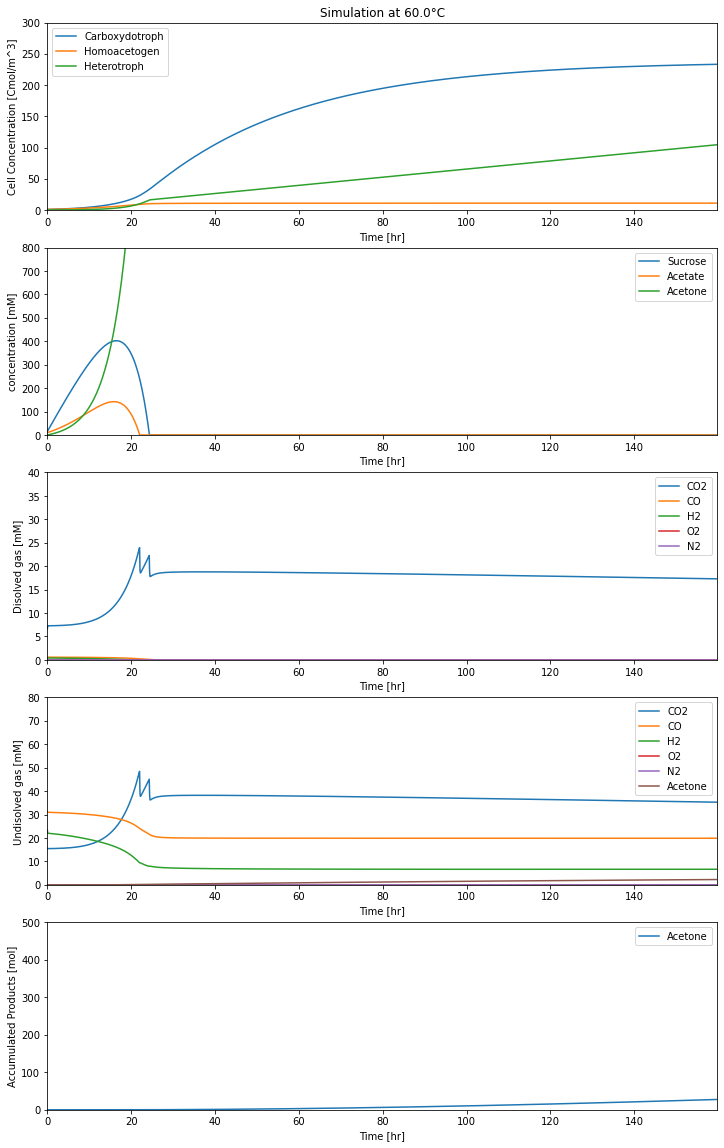

In [30]:
fig = plt.figure(figsize=(12,20))

t = concentrations.index
t_max = t[-1]

#Output results
plt.subplot(5,1,1)
plt.title(f"Simulation at {T-272.15}°C")
plt.plot(t,concentrations.Carboxydotroph)
plt.plot(t,concentrations.Homoacetogen)
plt.plot(t,concentrations.Heterotroph)
plt.xlabel('Time [hr]')
plt.ylabel('Cell Concentration [Cmol/m^3]')
plt.axis([0, t_max, 0, 300])
plt.legend(['Carboxydotroph','Homoacetogen','Heterotroph'])

plt.subplot(5,1,2)
plt.plot(t,concentrations.Sucrose)
plt.plot(t,concentrations.Acetate)
plt.plot(t,concentrations.Acetone)
plt.xlabel('Time [hr]')
plt.ylabel('concentration [mM]')
plt.axis([0, t_max, 0, 800])
plt.legend(['Sucrose','Acetate','Acetone'])

plt.subplot(5,1,3)
plt.plot(t,concentrations.CO2)
plt.plot(t,concentrations.CO)
plt.plot(t,concentrations.H2)
plt.plot(t,concentrations.O2)
plt.plot(t,concentrations.N2)
plt.xlabel('Time [hr]')
plt.ylabel('Disolved gas [mM]')
plt.axis([0, t_max, 0, 40])
plt.legend(['CO2','CO',"H2","O2","N2"])

plt.subplot(5,1,4)
plt.plot(t,concentrations.G_CO2)
plt.plot(t,concentrations.G_CO)
plt.plot(t,concentrations.G_H2)
plt.plot(t,concentrations.G_O2)
plt.plot(t,concentrations.G_N2)
plt.plot(t,concentrations.G_Actn)
plt.xlabel('Time [hr]')
plt.ylabel('Undisolved gas [mM]')
plt.axis([0, t_max, 0, 80])
plt.legend(['CO2','CO',"H2","O2","N2","Acetone"])

plt.subplot(5,1,5)
plt.plot(t,concentrations.Actn_acc/1000)
plt.xlabel('Time [hr]')
plt.ylabel('Accumulated Products [mol]')
plt.axis([0, t_max, 0, 500])
plt.legend(["Acetone"])

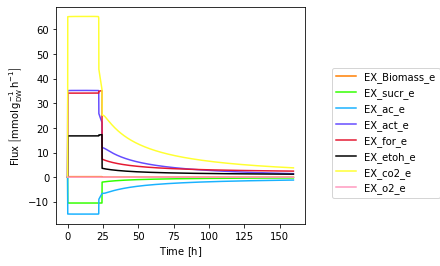

In [31]:
plot_trajectories(trajectories)

In [32]:
trajectories

,time,EX_Biomass_e,EX_sucr_e,EX_ac_e,EX_act_e,EX_for_e,EX_etoh_e,EX_co2_e,EX_o2_e
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.1,0.208994,-10.498440,-14.966083,35.149147,34.109467,16.745596,65.124920,0.0
2,0.2,0.208999,-10.498671,-14.967892,35.152249,34.110000,16.745855,65.131640,0.0
3,0.3,0.209002,-10.498843,-14.969533,35.155019,34.110357,16.746029,65.137693,0.0
4,0.4,0.209005,-10.498975,-14.971029,35.157514,34.110603,16.746148,65.143181,0.0
...,...,...,...,...,...,...,...,...,...
1593,159.3,0.006254,-0.314151,-1.178272,1.431337,2.452877,1.217188,3.789185,0.0
1594,159.4,0.006250,-0.313954,-1.177534,1.429950,2.452325,1.216918,3.786322,0.0
1595,159.5,0.006246,-0.313758,-1.176797,1.428564,2.451774,1.216649,3.783461,0.0
1596,159.6,0.006242,-0.313562,-1.176061,1.427179,2.451224,1.216379,3.780604,0.0
